# Introducción
Este notebook forma parte del TFM de clasifcación del cáncer de mama mediante deep learning. En él se pretende entrenar 4 modelos con el mismo conjunto de datos y obtener conclusiones. Para ello se divide en 5 apartados:
* Librería y directorios
* Exploración
* Pre-procesado
* Preparación de modelos
* Ejecución de modelos

El dataset elegido es MIAS (Mammographic Image Analysis Society), que contiene 322 mamografías digitalizadas en blanco y negro de 1024 x 1024 en formato PGM (Portable Gray Map).

  Suckling, J. et al. (2015) '&lsquo;'Mammographic Image Analysis Society (MIAS) database v1.21'. Apollo - University of Cambridge Repository. doi:10.17863/CAM.105113.



# 0. Librerías y directorios

Carga de librerías, directorios y el csv con la información de las mamografías.

In [23]:
import os  # Operaciones del sistema
import pandas as pd  # Manipulación de datos tabulares
import numpy as np  # Cálculos numéricos y algebra lineal

import matplotlib.pyplot as plt  # Gráficos y visualizaciones
import seaborn as sns  # Visualización de datos
import matplotlib.image as mpimg  # Cargar imágenes
from matplotlib.patches import Circle  # Dibujo de círculos
import matplotlib.ticker as ticker  # Formato de etiquetas en gráficos

from PIL import Image  # Manipulación de imágenes
from tensorflow.keras.preprocessing.image import load_img, img_to_array  # Procesar imágenes
from skimage.filters import threshold_otsu  # Umbral automático
from skimage.morphology import disk, opening, closing, white_tophat, black_tophat  # Morfología de imágenes
from skimage.measure import label, regionprops  # Análisis de regiones en imágenes
from scipy.ndimage import median_filter  # Filtro de mediana
from skimage.exposure import equalize_hist  # Ecualización de histograma

from sklearn.model_selection import train_test_split  # División de datos
import tensorflow as tf  # Redes neuronales
from tensorflow.keras import layers, models  # Construcción de modelos
from tensorflow.keras.applications import EfficientNetB0, VGG16, ResNet50, MobileNet  # Modelos preentrenados
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_efficient  # EfficientNet
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg  # VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet  # ResNet50
from tensorflow.keras.applications.mobilenet import preprocess_input as preprocess_mobilenet  # MobileNet

from sklearn.metrics import confusion_matrix, classification_report  # Métricas de evaluación

# Directorios
img_dir = r'D:\Daniel\Prácticas MÁSTER\TFM\dataset\miasdbv1.21'
img_proc = r'D:\Daniel\Prácticas MÁSTER\TFM\dataset\procesadas2'
csv_dir = r'D:\Daniel\Prácticas MÁSTER\TFM\dataset\DETALLE_MIAS.CSV'

In [24]:
# Leer CSV
df = pd.read_csv(csv_dir, sep=';')

# Etiquetas
df['TIPO'] = df['TIPO'].map({'B': 1, 'M': 2}).fillna(0).astype(int)
contador_etiquetas = df['TIPO'].value_counts()
total = contador_etiquetas.sum()
class_weights = {cl: total / (len(contador_etiquetas) * count) for cl, count in contador_etiquetas.items()}


# 1. Exploración

En este apartado se muestra cómo está distribuido el conjunto de datos en función del tejido y del tipo de tumor. También se muestran 2 imágenes como representación del conjunto.

In [41]:
df.head()

,ID,TEJIDO,CLASE,TIPO,X,Y,RADIO
0,mdb001lm,G,CIRC,1,1815.0,1116.0,790.0
1,mdb002rl,G,CIRC,1,3091.0,1262.0,277.0
2,mdb003ll,D,NORM,0,NaN,NaN,NaN
3,mdb004rl,D,NORM,0,NaN,NaN,NaN
4,mdb005ll,F,CIRC,1,647.0,1163.0,122.0


In [42]:
print(f"Tamaño del dataset: {len(df)}")

Tamaño del dataset: 330


El df contiene la información extraída del csv que complementa el conjunto de imágenes del dataset MIAS. Contiene 330 filas (algunas mamografías contienen más de una lesión) y 7 columnas:
* ID: Identificador de la imagen. Las primeras 3 letras son comunes, después un secuencial de tres dígitos y dos letras finales que indican el pecho (left, right) y el tamaño ('s', 'm', 'l' o 'x').
* TEJIDO: Tipo de tejido del pecho (F - Graso, G - Graso-glandular, D - Denso-glandular).
* CLASE: Clase de la lesión.
    * CALC - Calcificación
    * CIRC - Masas bien definidas/circunscritas
    * SPIC - Masas espiculadas
    * MISC - Otras masas mal definidas
    * ARCH - Distorsión arquitectónica
    * ASYM - Asimetría
    * NORM - Normal
* TIPO: Tipo de tumor (0: Sin tumor, 1: Benigno, 2: Maligno).
* X: Coordenada x de la lesión.
* Y: Coordenada y de la lesión.
* RADIO: Radio de la lesión.

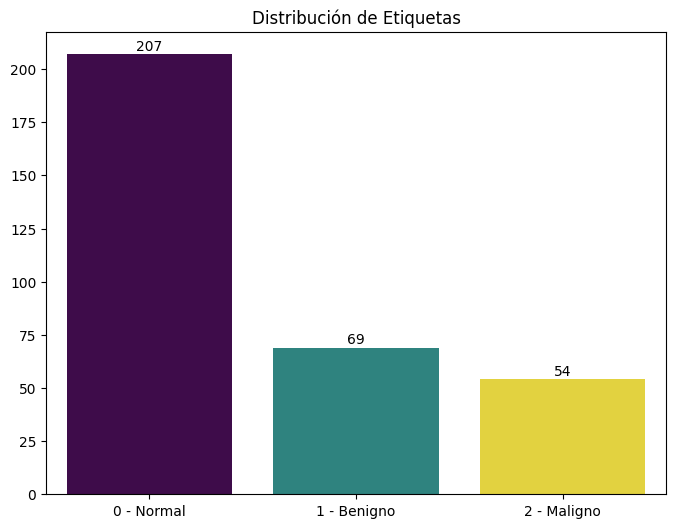

In [ ]:
# Distribución de etiquetas
plt.figure(figsize=(8, 6))
sns.barplot(x=contador_etiquetas.index, y=contador_etiquetas.values, hue=contador_etiquetas.index, palette='viridis', dodge=False, legend=False)
plt.title('Distribución de Etiquetas')
plt.xlabel('')
plt.ylabel('')
plt.xticks(ticks=[0, 1, 2], labels=['0 - Normal', '1 - Benigno', '2 - Maligno'])

for i, value in enumerate(contador_etiquetas.values):
    plt.text(i, value + 2, str(value), ha='center')

plt.show()

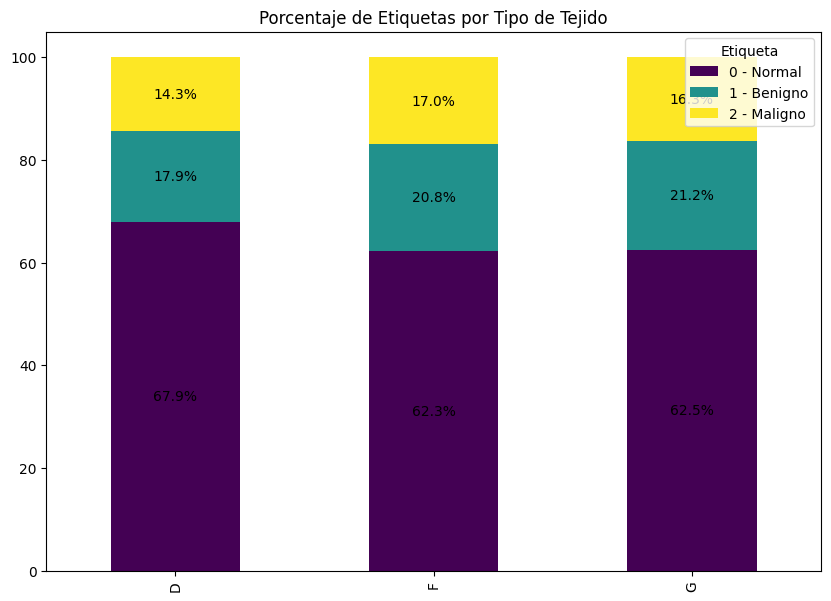

In [ ]:
# Porcentaje de etiquetas por tipo de tejido
df_tejido_tipo = df.groupby('TEJIDO')['TIPO'].value_counts(normalize=True).unstack().fillna(0) * 100

ax = df_tejido_tipo.plot(kind='bar', stacked=True, figsize=(10, 7), colormap='viridis')
plt.title('Porcentaje de Etiquetas por Tipo de Tejido')
plt.xlabel('')
plt.ylabel('')
plt.legend(title='Etiqueta', labels=['0 - Normal', '1 - Benigno', '2 - Maligno'], loc='upper right')

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='center')

plt.show()

In [28]:
def mostrar_imagenes_con_coordenadas(data_dir, df, image_list):
    """
    Muestra imágenes específicas de un directorio con imágenes PGM individualmente
    y añade círculos en las coordenadas especificadas en el DataFrame.
    
    Parameters:
    - data_dir (str): Ruta al directorio que contiene las imágenes.
    - df (pd.DataFrame): DataFrame que contiene las coordenadas.
    - image_list (list): Lista de nombres de archivos de imágenes a mostrar.

    Returns:
    - Imágenes
    """
    for file_name in image_list:
        file_id = os.path.splitext(file_name)[0]
        file_path = os.path.join(data_dir, file_name)
        
        # Verificar si el archivo existe
        if not os.path.exists(file_path):
            print(f"El archivo {file_path} no existe. Saltando a la siguiente imagen.")
            continue
        
        img = mpimg.imread(file_path)
        
        # Crear una nueva figura para cada imagen
        plt.figure(figsize=(9, 9))
        plt.imshow(img, cmap='gray')
        
        # Obtener la fila completa del DataFrame correspondiente al ID actual
        fila = df[df['ID'] == file_id].iloc[0]
        titulo = f"ID: {fila['ID']}, TEJIDO: {fila['TEJIDO']}, CLASE: {fila['CLASE']}, TIPO: {fila['TIPO']}, X: {fila['X']}, Y: {fila['Y']}, RADIO: {fila['RADIO']}"
        plt.title(titulo)

        ax = plt.gca()

        # Definir cuadrícula
        ax.grid(True, which='major', linestyle='--', linewidth=0.5, color='gray')
        ax.minorticks_on()
        ax.xaxis.set_minor_locator(ticker.MultipleLocator(250))
        ax.yaxis.set_minor_locator(ticker.MultipleLocator(250))
        ax.grid(True, which='minor', linestyle=':', linewidth=0.5, color='lightgray')


        # Dibujar círculos en las coordenadas  
        coordenadas = df[df['ID'] == file_id][['X', 'Y', 'RADIO']]
        image_height = img.shape[0]
               
        for _, row in coordenadas.iterrows():
            x = row['X']
            y = row['Y']
            adjusted_y = image_height - y  # Invertir el eje Y

            if pd.notnull(row['RADIO']): # Si RADIO no es nulo, dibujar un círculo
                radio = row['RADIO']
                circle = Circle((x, adjusted_y), radius=radio, color='red', fill=False, linewidth=1)
                ax.add_patch(circle)
            elif pd.notnull(x) and pd.notnull(y): # Si RADIO es nulo pero x, y son válidos, dibujar un punto
                ax.plot(x, adjusted_y, 'ro')

        plt.show()

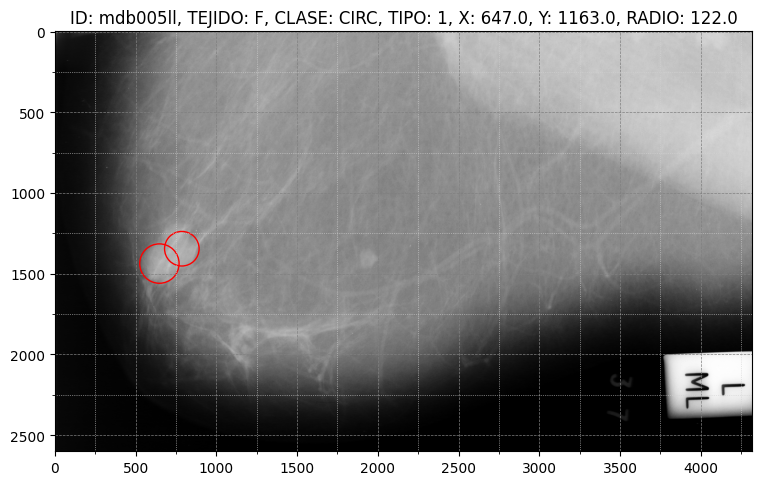

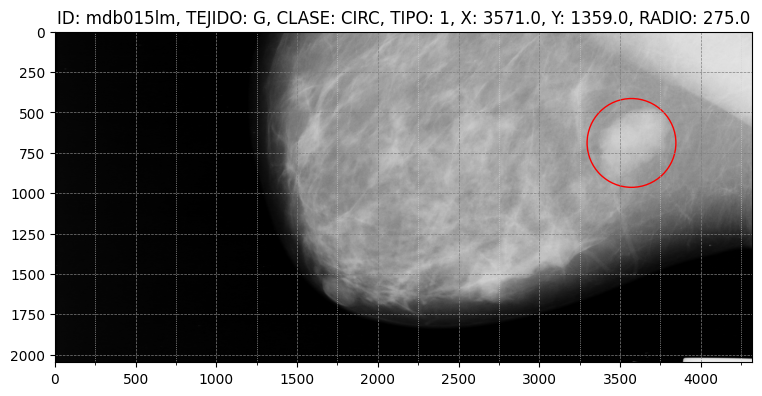

In [30]:
image_list = [
'mdb005ll.pgm',
'mdb015lm.pgm'
]
mostrar_imagenes_con_coordenadas(img_dir, df, image_list)

# 2. Pre-procesado

Se utilizan distintas herramientas para realizar un pre-procesado a las imágenes con la finalidad de facilitar la ingesta por los modelos. Como resultado se muestra un ejemplo de imágenes originales y procesadas.

In [ ]:
os.makedirs(img_proc, exist_ok=True)

# Parametrización
struct_elem = disk(1)  # Elemento estructurante pequeño
target_size = (224, 224)  # Tamaño de salida ejemplo

for idx, row in df.iterrows():
    img_name = row['ID']
    img_path = os.path.join(img_dir, img_name + '.pgm')
    
    # Cargar imagen (grayscale)
    try:
        pil_img = load_img(img_path, color_mode='grayscale')
    except:
        continue
    
    img = img_to_array(pil_img).astype('uint8')
    img = np.squeeze(img)

    # Eliminación de ruido (mediana)
    img = median_filter(img, size=3)

    # Equalización de histograma
    img_eq = (equalize_hist(img) * 255).astype('uint8')

    # Análisis morfológico
    IO = opening(img_eq, struct_elem)
    IC = closing(img_eq, struct_elem)
    WTH = white_tophat(img_eq, struct_elem)
    BTH = black_tophat(img_eq, struct_elem)
    MM = img_eq + WTH - BTH

    # Segmentación (Otsu)
    thresh = threshold_otsu(MM)
    seg_mask = (MM > thresh).astype(np.uint8) * 255
    seg_img = MM * (seg_mask // 255)

    # Extraer solo la región con tejido mamario
    # Convertir la máscara en booleano
    binary_mask = seg_mask > 0
    # Cerrar huecos
    binary_mask = closing(binary_mask, disk(5))
    # Etiquetar y encontrar la región más grande
    labeled = label(binary_mask)
    regions = regionprops(labeled)
    if len(regions) > 0:
        regions = sorted(regions, key=lambda r: r.area, reverse=True)
        largest_region = regions[0]
        breast_mask = (labeled == largest_region.label)
        breast_region = MM * breast_mask.astype(np.uint8)
    else:
        breast_region = MM

    # Redimensionar y pasar a RGB
    seg_img_pil = Image.fromarray(breast_region)
    seg_img_pil = seg_img_pil.resize(target_size)
    seg_img_pil = seg_img_pil.convert("RGB")

    # Guardar resultado
    out_path = os.path.join(img_proc, img_name + '_proc.png')
    seg_img_pil.save(out_path)

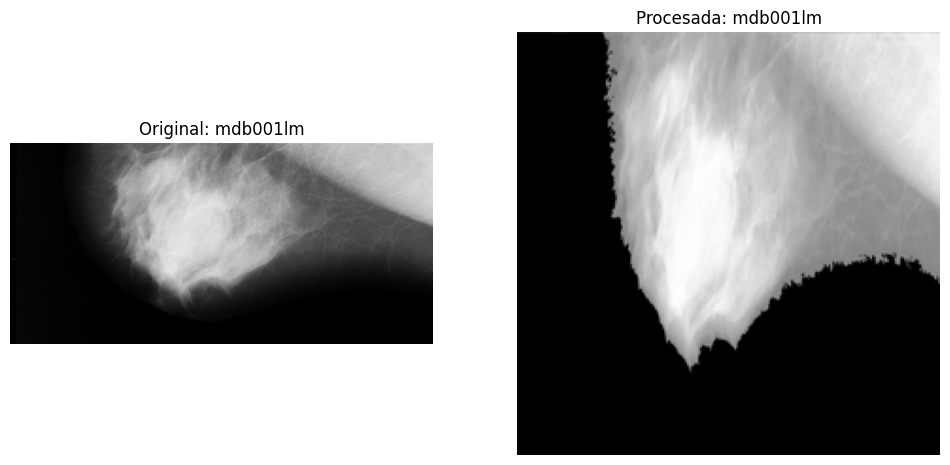

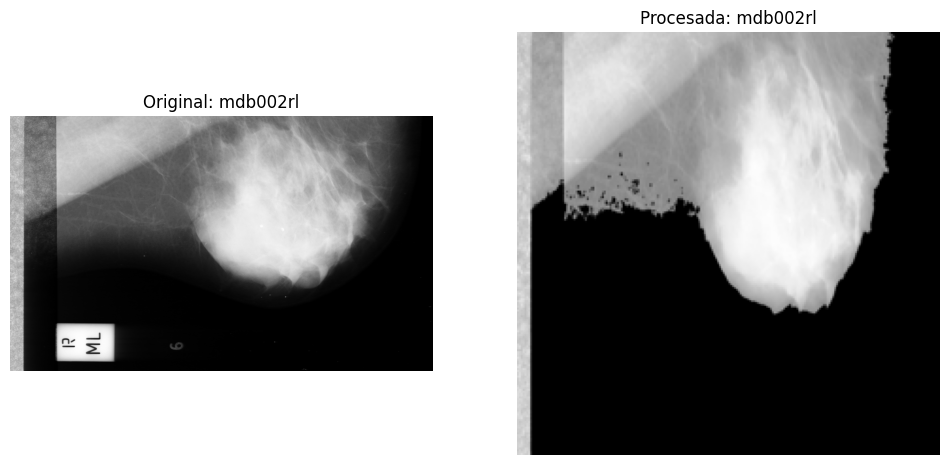

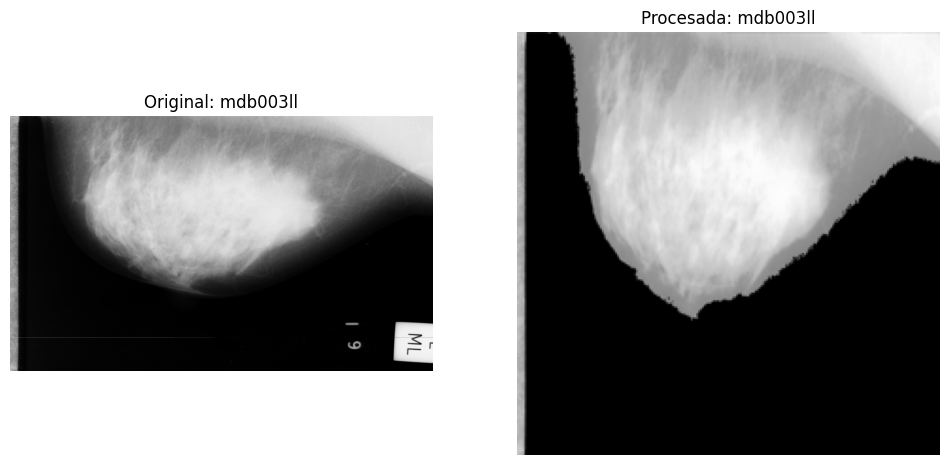

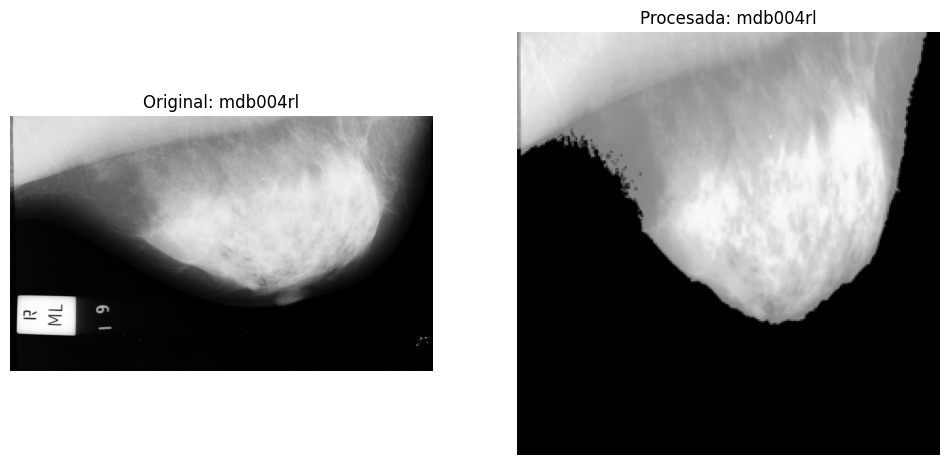

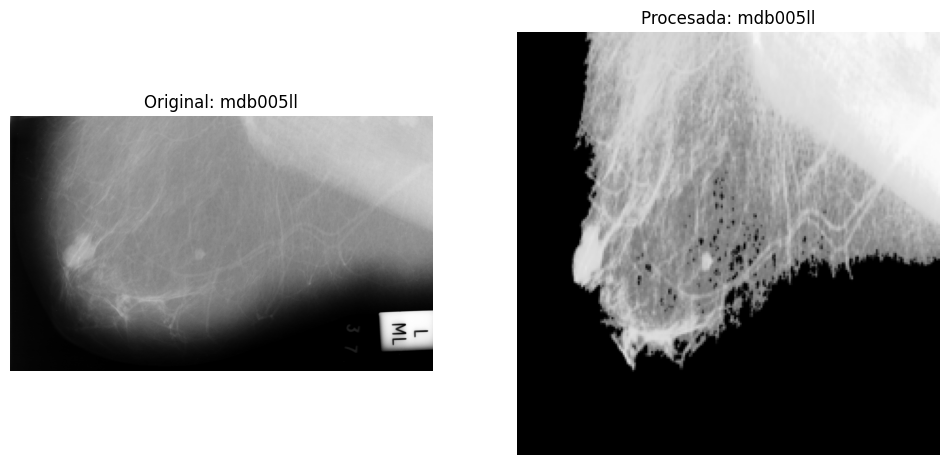

In [31]:
def comparar_imagenes(img_dir, img_proc, df, num_imagenes=5):
    """
    Compara las primeras `num_imagenes` imágenes de los directorios `img_dir` y `img_proc`.
    
    Parámetros:
    - img_dir (str): Ruta al directorio original de imágenes.
    - img_proc (str): Ruta al directorio de imágenes procesadas.
    - df (pd.DataFrame): DataFrame que contiene los nombres de las imágenes.
    - num_imagenes (int): Número de imágenes a comparar.

    Retorno:
    - Imágenes comparadas
    """
    for i in range(num_imagenes):
        img_name = df.iloc[i]['ID']
        img_path_original = os.path.join(img_dir, img_name + '.pgm')
        img_path_procesada = os.path.join(img_proc, img_name + '_proc.png')
        
        # Cargar imágenes
        img_original = mpimg.imread(img_path_original)
        img_procesada = mpimg.imread(img_path_procesada)
        
        # Mostrar imágenes lado a lado
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].imshow(img_original, cmap='gray')
        axes[0].set_title(f'Original: {img_name}')
        axes[0].axis('off')
        
        axes[1].imshow(img_procesada)
        axes[1].set_title(f'Procesada: {img_name}')
        axes[1].axis('off')
        
        plt.show()

comparar_imagenes(img_dir, img_proc, df)

# 3. Preparación de modelos

Después del preprocesado pasamos a cargar los datos y a crear la función de aumento de datos, en este caso con aumento sobre la marcha.

Después se crean los modelos elegidos: EfficientNetB0, VGG16, ResNet50 y MobileNet.

Por último se crea una función para valdiar los modelos.

## Carga y aumento

In [10]:
X = df['ID'].apply(lambda x: os.path.join(img_proc, x + '_proc.png')).values
y = df['TIPO'].values  

# Separar en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Función para cargar y procesar imágenes
def load_and_preprocess_image(path, label):
    """
    Carga y preprocesa una imagen desde una ruta dada y la etiqueta correspondiente.

    Parámetros:
        path (str): Ruta del archivo de imagen.
        label (int): Etiqueta asociada a la imagen.

    Retorno:
        tupla: Imagen procesada y etiqueta.
    """
    img_raw = tf.io.read_file(path)
    img = tf.image.decode_png(img_raw, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img, label


# Aumento de datos
def augment_image(img, label):
    """
    Aplica una serie de aumentos aleatorios a una imagen.

    Esta función realiza los siguientes aumentos:
    - Voltea la imagen aleatoriamente de izquierda a derecha.
    - Voltea la imagen aleatoriamente de arriba a abajo.
    - Ajusta aleatoriamente el brillo de la imagen.

    Parámetros:
        img (tf.Tensor): El tensor de imagen de entrada.
        label (Any): La etiqueta asociada con la imagen.

    Retorno:
        Tuple[tf.Tensor, Any]: El tensor de imagen aumentado y la etiqueta original.
    """
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_brightness(img, max_delta=0.1)
    return img, label


# Crear tf.data datasets
batch_size = 32

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(len(X_train)) \
                   .map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE) \
                   .map(augment_image, num_parallel_calls=tf.data.AUTOTUNE) \
                   .batch(batch_size) \
                   .prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE) \
                 .batch(batch_size) \
                 .prefetch(tf.data.AUTOTUNE)


## Construcción de modelos

In [59]:
num_classes = 3
input_shape = (224, 224, 3)

def build_efficientnetb0(layers_to_unfreeze=4):
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)
    # Congelar todas las capas
    for layer in base_model.layers:
        layer.trainable = False
    # Descongelar las últimas capas
    for layer in base_model.layers[-layers_to_unfreeze:]:
        layer.trainable = True
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def build_vgg16(layers_to_unfreeze=4):
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    # Congelar todas las capas
    for layer in base_model.layers:
        layer.trainable = False
    # Descongelar las últimas capas
    for layer in base_model.layers[-layers_to_unfreeze:]:
        layer.trainable = True
    x = layers.Flatten()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def build_resnet50(layers_to_unfreeze=4):
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    # Congelar todas las capas
    for layer in base_model.layers:
        layer.trainable = False
    # Descongelar las últimas capas
    for layer in base_model.layers[-layers_to_unfreeze:]:
        layer.trainable = True
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def build_mobilenet(layers_to_unfreeze=4):
    base_model = MobileNet(include_top=False, weights='imagenet', input_shape=input_shape)
    # Congelar todas las capas
    for layer in base_model.layers:
        layer.trainable = False
    # Descongelar las últimas capas
    for layer in base_model.layers[-layers_to_unfreeze:]:
        layer.trainable = True
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


## Función de validación

In [60]:
# Obtener etiquetas verdaderas del dataset de test
y_true = np.concatenate([y for x, y in test_ds], axis=0)

def evaluate_model(model, history, model_name):
    """
    Evalúa un modelo de clasificación y muestra gráficos de pérdida, precisión y matriz de confusión.

    Parámetros:
    - model (tf.keras.Model): Modelo entrenado.
    - history (tf.keras.History): Historial de entrenamiento.
    - model_name (str): Nombre del modelo.

    Retorno:
    - Visualizaciones
    """
    # Obtener predicciones del modelo (probabilidades)
    y_pred_probs = model.predict(test_ds)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Gráfico de pérdida y precisión
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Entrenamiento')
    plt.plot(history.history['val_loss'], label='Validación')
    plt.title('Pérdida durante el entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Validación')
    plt.title('Precisión durante el entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()

    plt.show()

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    print("Matriz de confusión:")
    print(cm)

    # Métricas principales
    print("\nReporte de clasificación:")
    print(classification_report(y_true, y_pred, target_names=["vacío", "B", "M"]))

    # Gráfico de la matriz de confusión
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["vacío", "B", "M"], yticklabels=["vacío", "B", "M"])
    plt.xlabel('Predicción')
    plt.ylabel('Verdadero')
    plt.title(f'Matriz de confusión - {model_name}')
    plt.show()

# 4. Ejecución modelos

En el último apartado se entrenan los modelos con el mismo conjunto de datos y pesos de las clases.

## EfficientNet

In [61]:
model_efficient = build_efficientnetb0()
history_efficient = model_efficient.fit(train_ds, validation_data=test_ds, epochs=20, class_weight=class_weights)

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.2733 - loss: 1.2624 - val_accuracy: 0.5000 - val_loss: 1.0116
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5402 - loss: 0.9677 - val_accuracy: 0.2576 - val_loss: 1.3181
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.4554 - loss: 0.9071 - val_accuracy: 0.4394 - val_loss: 1.1056
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5553 - loss: 0.8110 - val_accuracy: 0.4848 - val_loss: 1.0800
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6707 - loss: 0.7592 - val_accuracy: 0.4091 - val_loss: 1.1108
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6415 - loss: 0.7255 - val_accuracy: 0.3333 - val_loss: 1.2777
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6668 - loss: 0.6737 - val_accuracy: 0.4394 - val_loss: 1.1532
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8113 - loss: 0.5605 - val_accuracy: 0.3333 - val_loss: 1.2810
Epoch 9/

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step  


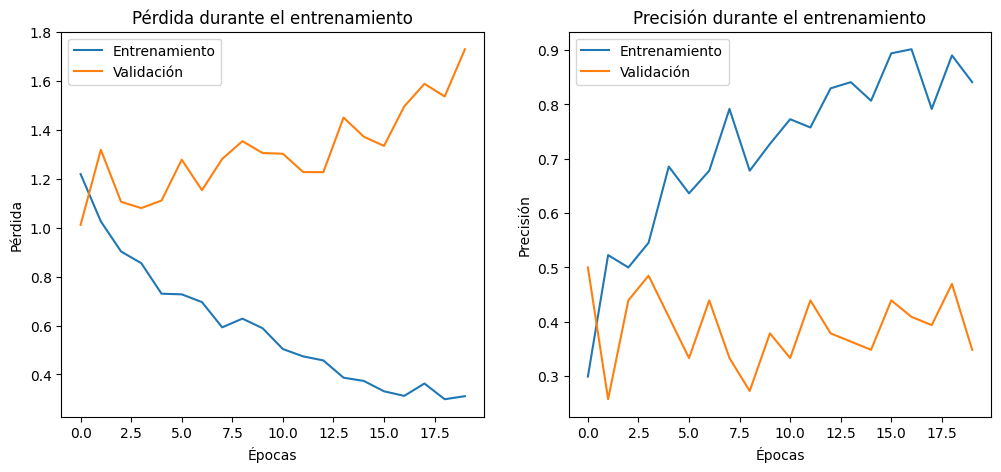

Matriz de confusión:
[[16 13 12]
 [ 5  5  4]
 [ 4  5  2]]

Reporte de clasificación:
              precision    recall  f1-score   support

       vacío       0.64      0.39      0.48        41
           B       0.22      0.36      0.27        14
           M       0.11      0.18      0.14        11

    accuracy                           0.35        66
   macro avg       0.32      0.31      0.30        66
weighted avg       0.46      0.35      0.38        66



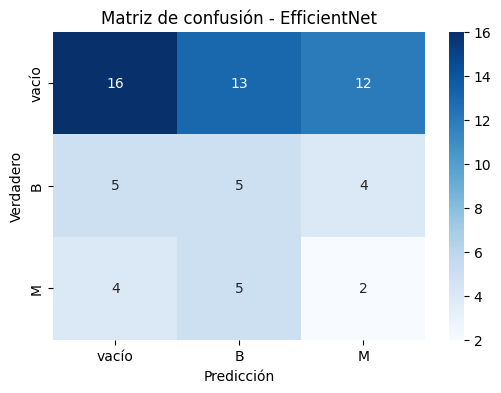

In [62]:
evaluate_model(model_efficient, history_efficient, 'EfficientNet')

## VGG16

In [63]:
model_vgg = build_vgg16()
history_vgg = model_vgg.fit(train_ds, validation_data=test_ds, epochs=20, class_weight=class_weights)

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 68s 7s/step - accuracy: 0.3901 - loss: 18.8307 - val_accuracy: 0.3636 - val_loss: 1.0441
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 66s 7s/step - accuracy: 0.3867 - loss: 1.3372 - val_accuracy: 0.4848 - val_loss: 1.0603
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 68s 8s/step - accuracy: 0.3421 - loss: 1.7455 - val_accuracy: 0.2121 - val_loss: 1.1130
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 67s 8s/step - accuracy: 0.1995 - loss: 1.0965 - val_accuracy: 0.1667 - val_loss: 1.1161
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 67s 8s/step - accuracy: 0.1655 - loss: 1.1179 - val_accuracy: 0.2121 - val_loss: 1.1172
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 67s 8s/step - accuracy: 0.1924 - loss: 2.8390 - val_accuracy: 0.1667 - val_loss: 1.1143
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 67s 8s/step - accuracy: 0.1686 - loss: 1.0525 - val_accuracy: 0.1667 - val_loss: 1.1127
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 67s 8s/step - accuracy: 0.1510 - loss: 1.0415 - val_accuracy: 0.2121 - val_loss: 1.1115
Epoch 9

3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step


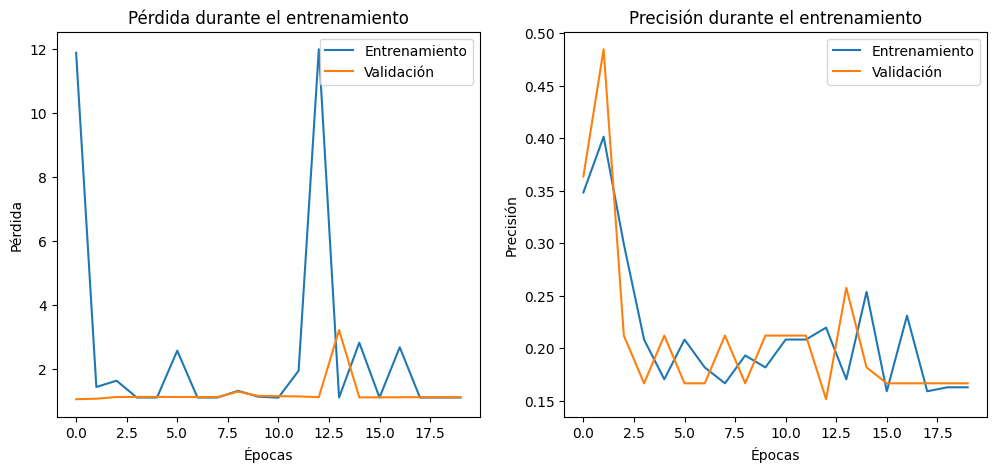

Matriz de confusión:
[[ 0  0 41]
 [ 0  0 14]
 [ 0  0 11]]

Reporte de clasificación:
              precision    recall  f1-score   support

       vacío       0.00      0.00      0.00        41
           B       0.00      0.00      0.00        14
           M       0.17      1.00      0.29        11

    accuracy                           0.17        66
   macro avg       0.06      0.33      0.10        66
weighted avg       0.03      0.17      0.05        66



d:\Daniel\Prácticas MÁSTER\TFM\código\bc-env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Daniel\Prácticas MÁSTER\TFM\código\bc-env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Daniel\Prácticas MÁSTER\TFM\código\bc-env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

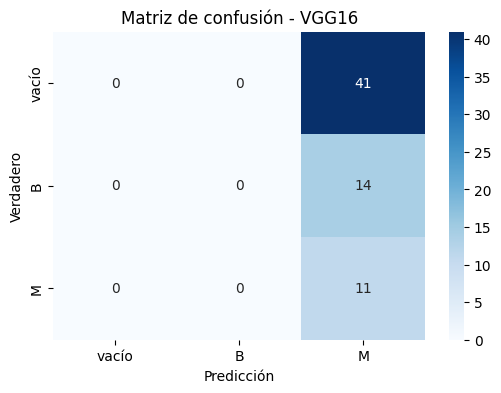

In [64]:
evaluate_model(model_vgg, history_vgg, 'VGG16')

## ResNet50

In [65]:
model_resnet = build_resnet50()
history_resnet = model_resnet.fit(train_ds, validation_data=test_ds, epochs=20, class_weight=class_weights)

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.3412 - loss: 1.6108 - val_accuracy: 0.3636 - val_loss: 1.3350
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.4417 - loss: 1.3768 - val_accuracy: 0.1970 - val_loss: 2.7591
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.2986 - loss: 1.5469 - val_accuracy: 0.5303 - val_loss: 1.5129
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.4619 - loss: 1.0492 - val_accuracy: 0.5455 - val_loss: 1.1136
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.5298 - loss: 0.9606 - val_accuracy: 0.5758 - val_loss: 1.2587
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.5826 - loss: 0.9550 - val_accuracy: 0.3788 - val_loss: 1.1563
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.5683 - loss: 0.8156 - val_accuracy: 0.5303 - val_loss: 1.2000
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.5864 - loss: 0.7944 - val_accuracy: 0.4848 - val_loss: 1.1834
Epoch 9/

3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


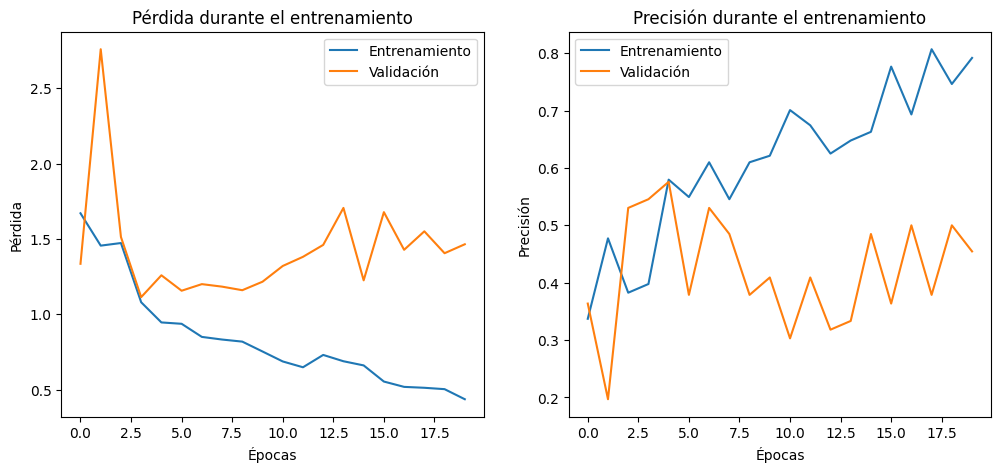

Matriz de confusión:
[[24 11  6]
 [ 7  6  1]
 [ 4  7  0]]

Reporte de clasificación:
              precision    recall  f1-score   support

       vacío       0.69      0.59      0.63        41
           B       0.25      0.43      0.32        14
           M       0.00      0.00      0.00        11

    accuracy                           0.45        66
   macro avg       0.31      0.34      0.32        66
weighted avg       0.48      0.45      0.46        66



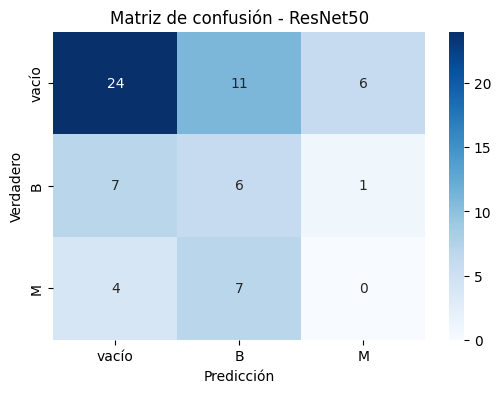

In [66]:
evaluate_model(model_resnet, history_resnet, 'ResNet50')

## MobileNet

In [67]:
model_mobilenet = build_mobilenet()
history_mobilenet = model_mobilenet.fit(train_ds, validation_data=test_ds, epochs=20, class_weight=class_weights)

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 754ms/step - accuracy: 0.3444 - loss: 2.3521 - val_accuracy: 0.1667 - val_loss: 4.0334
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 706ms/step - accuracy: 0.5573 - loss: 1.4187 - val_accuracy: 0.1667 - val_loss: 9.9485
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 706ms/step - accuracy: 0.3042 - loss: 1.3432 - val_accuracy: 0.1667 - val_loss: 3.7103
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 697ms/step - accuracy: 0.4704 - loss: 1.1356 - val_accuracy: 0.1667 - val_loss: 4.1280
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 693ms/step - accuracy: 0.4566 - loss: 1.0424 - val_accuracy: 0.1667 - val_loss: 3.3455
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 704ms/step - accuracy: 0.4679 - loss: 1.0639 - val_accuracy: 0.1667 - val_loss: 2.7582
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 702ms/step - accuracy: 0.5571 - loss: 1.0382 - val_accuracy: 0.1212 - val_loss: 2.5978
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 702ms/step - accuracy: 0.5251 - loss: 0.9112 - val_accuracy: 0.1667 - val_loss

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 769ms/step


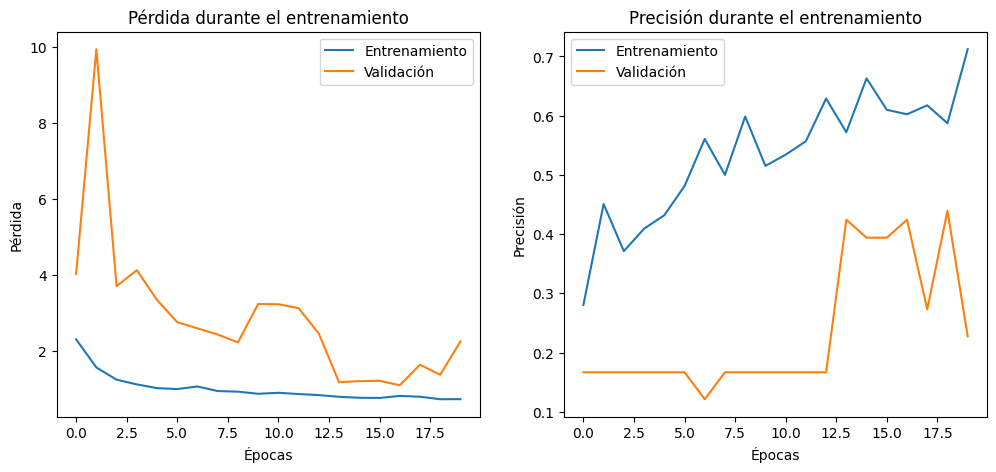

Matriz de confusión:
[[ 2 39  0]
 [ 1 13  0]
 [ 2  9  0]]

Reporte de clasificación:
              precision    recall  f1-score   support

       vacío       0.40      0.05      0.09        41
           B       0.21      0.93      0.35        14
           M       0.00      0.00      0.00        11

    accuracy                           0.23        66
   macro avg       0.20      0.33      0.14        66
weighted avg       0.29      0.23      0.13        66



d:\Daniel\Prácticas MÁSTER\TFM\código\bc-env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Daniel\Prácticas MÁSTER\TFM\código\bc-env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Daniel\Prácticas MÁSTER\TFM\código\bc-env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

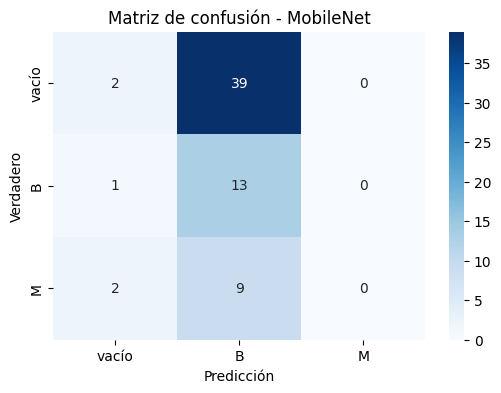

In [68]:
evaluate_model(model_mobilenet, history_mobilenet, 'MobileNet')